$\color{red}{\text{Notebook 4 voxel morph contains a code that utilizes voxelmorph library to transform the images with training it.}}$
$\color{red}{\text{It firstly trains the model on MNIST dataset, they trains it back with both images. Due to the lack of dataset, the training}}$
$\color{red}{\text{result is not very accurate, but demonestrates that it works.}}$

$\color{red}{\text{Lab members:}}$
- $\color{red}{\text{Abdelrahman Usama Gabr Abdou Habib}}$

Source:
- ###### https://colab.research.google.com/drive/1PJ-aRZrkU-2SfVEIBlg8kHRJZrjdnmOT#scrollTo=OvmVFKcpPXPO

In [2]:
!pip uninstall tensorflow -y 
!pip install tensorflow==2.4.1
!pip install voxelmorph 

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.4.1
You should consider upgrading via the 'C:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\MIRA\code\env\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\MIRA\code\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [42]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This notebook assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne

from tensorflow.keras.datasets import mnist

In [216]:
# load MNIST data. 
# `mnist.load_data()` already splits our data into train and test.  
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

shape of x_train: (5421, 28, 28), y_train: (5421,)


In [217]:
nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

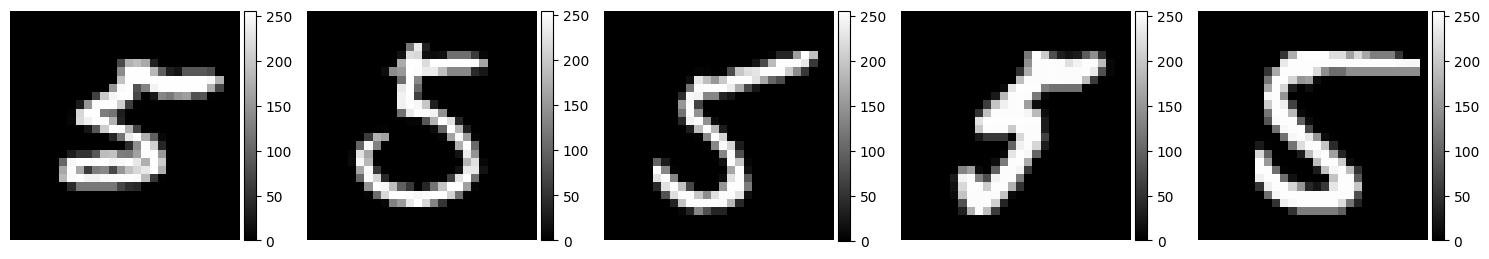

In [218]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [219]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


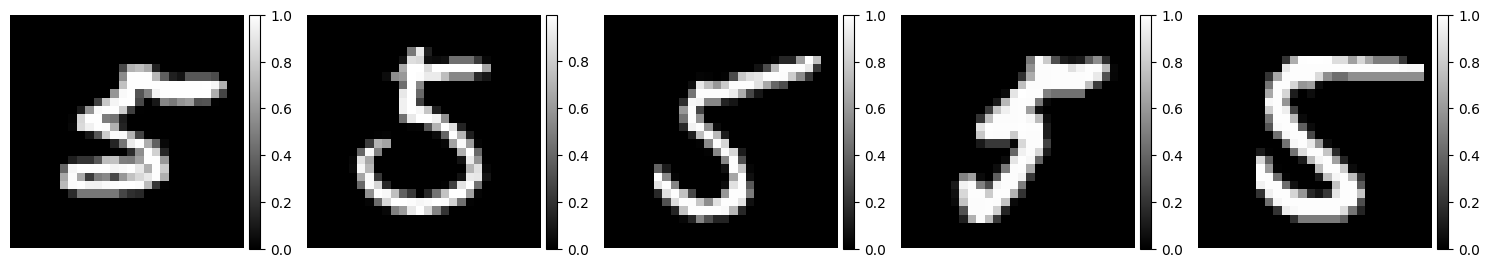

In [220]:
# re-visualize
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [221]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)
print('shape of validation data', x_val.shape)
print('shape of test data', x_test.shape)

shape of training data (4421, 32, 32)
shape of validation data (1000, 32, 32)
shape of test data (892, 32, 32)


In [222]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

print("inshape: ", inshape)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder arm features
    [32, 32, 32, 32, 32, 16]  # decoder arm features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

inshape:  (32, 32, 2)


In [223]:
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 16)


In [224]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 32, 32, 2)


In [225]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 32, 32, 2)


In [226]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = unet.input[..., 0, tf.newaxis]

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

In [227]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

In [228]:
inshape

(32, 32, 2)

In [229]:
x_train.shape[1:]

(32, 32)

In [230]:
nb_features

[[32, 32, 32, 32], [32, 32, 32, 32, 32, 16]]

In [231]:
# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

In [232]:
vxm_model.summary()

Model: "vxm_dense"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vxm_dense_source_input (In  [(None, 32, 32, 1)]          0         []                            
 putLayer)                                                                                        
                                                                                                  
 vxm_dense_target_input (In  [(None, 32, 32, 1)]          0         []                            
 putLayer)                                                                                        
                                                                                                  
 vxm_dense_unet_input_conca  (None, 32, 32, 2)            0         ['vxm_dense_source_input[0][0]
 t (Concatenate)                                                    ',                    

In [233]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 32, 32, 1), (None, 32, 32, 1)
output shape: (None, 32, 32, 1), (None, 32, 32, 2)


In [234]:
# loss terms
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [235]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [236]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    nb_items = x_data.shape[0]
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, nb_items, size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, nb_items, size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image, so we return 
        # the fixed image. 
        # Bescause keras requires a 'true' item for each output, we 
        # return a volume of zeros -- this won't be used in the end.  
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [237]:
x_train.shape

(4421, 32, 32)

In [254]:
x_train.shape

(1, 32, 32)

(2, 32, 32, 32, 1)


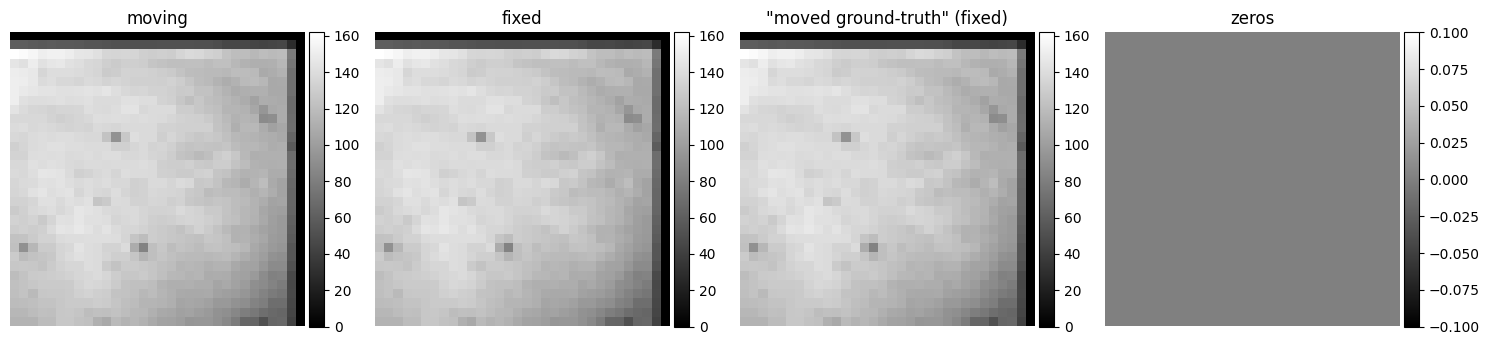

In [253]:
# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

print(np.array(in_sample).shape)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', '"moved ground-truth" (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [63]:
# finally, let's train a model
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10
100/100 - 6s - loss: 0.0519 - vxm_dense_transformer_loss: 0.0488 - vxm_dense_flow_loss: 0.0612 - 6s/epoch - 57ms/step
Epoch 2/10
100/100 - 3s - loss: 0.0226 - vxm_dense_transformer_loss: 0.0175 - vxm_dense_flow_loss: 0.1020 - 3s/epoch - 32ms/step
Epoch 3/10
100/100 - 3s - loss: 0.0180 - vxm_dense_transformer_loss: 0.0130 - vxm_dense_flow_loss: 0.0985 - 3s/epoch - 31ms/step
Epoch 4/10
100/100 - 3s - loss: 0.0152 - vxm_dense_transformer_loss: 0.0106 - vxm_dense_flow_loss: 0.0923 - 3s/epoch - 32ms/step
Epoch 5/10
100/100 - 3s - loss: 0.0143 - vxm_dense_transformer_loss: 0.0097 - vxm_dense_flow_loss: 0.0920 - 3s/epoch - 30ms/step
Epoch 6/10
100/100 - 3s - loss: 0.0135 - vxm_dense_transformer_loss: 0.0089 - vxm_dense_flow_loss: 0.0907 - 3s/epoch - 32ms/step
Epoch 7/10
100/100 - 3s - loss: 0.0126 - vxm_dense_transformer_loss: 0.0082 - vxm_dense_flow_loss: 0.0890 - 3s/epoch - 32ms/step
Epoch 8/10
100/100 - 3s - loss: 0.0119 - vxm_dense_transformer_loss: 0.0076 - vxm_dense_flow_loss

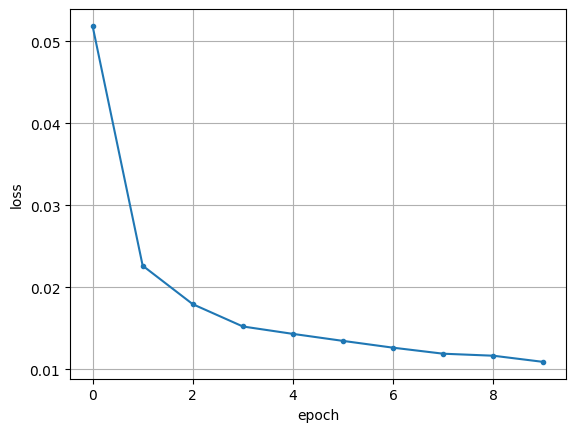

In [64]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

plot_history(hist)

In [65]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size=1)
val_input, _ = next(val_generator)

In [66]:
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 0s 248ms/step


In [67]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

1/1 [==============================] - 0s 28ms/step
63.7 ms ± 5.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


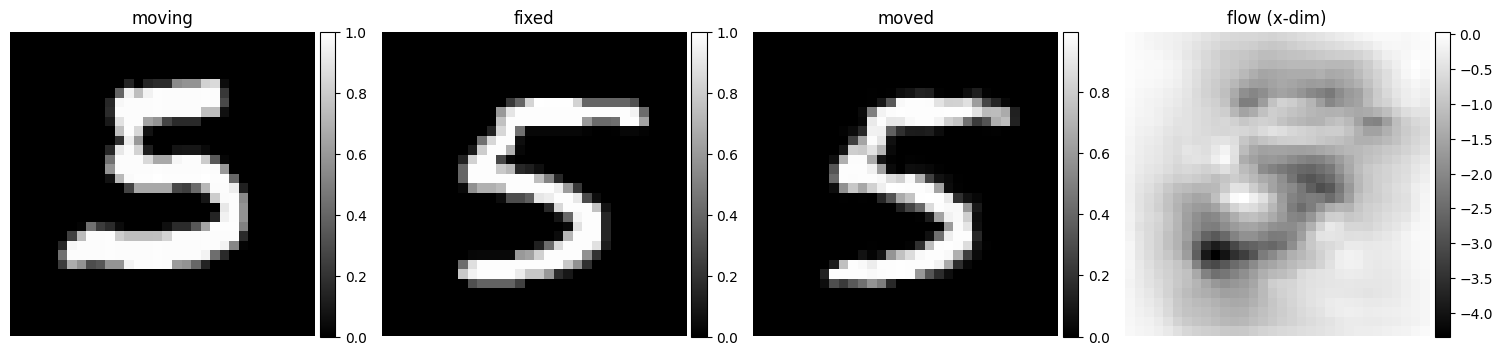

In [68]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow (x-dim)']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

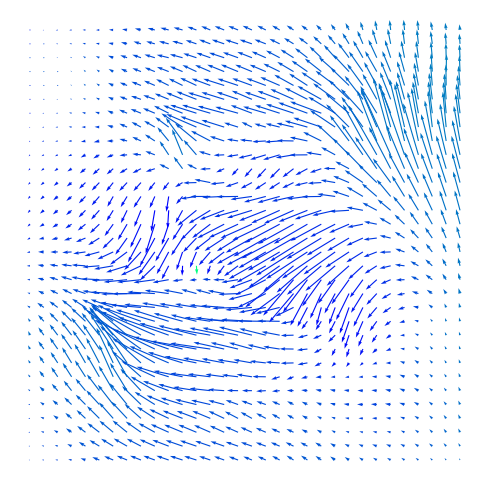

In [70]:
# flow is a plotting functionality in `neurite`
ne.plot.flow([val_pred[1].squeeze()], width=5);

In [408]:
from PIL import Image

# x_train = np.array(Image.open('./moving/skin1.png').convert('L').resize((32, 32)))
# x_val = np.array(Image.open('./fixed/skin2.png').convert('L').resize((32, 32)))
moving_image = np.array(Image.open('./moving/skin1.png').convert('L').resize((224, 224)))
fixed_image = np.array(Image.open('./fixed/skin2.png').convert('L').resize((224, 224)))

# Stack the images into a single array
x_train = np.stack([moving_image, fixed_image])
x_val = np.stack([moving_image, fixed_image])

print('train shape:', x_train.shape)
vol_shape = x_train.shape[1:]

train shape: (2, 224, 224)


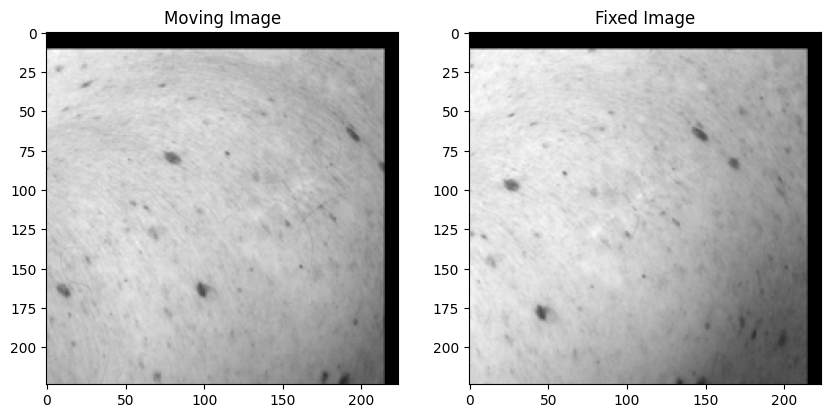

In [409]:
# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot moving_image
axes[0].imshow(x_train[0], cmap='gray')
axes[0].set_title('Moving Image')

# Plot fixed_image
axes[1].imshow(x_train[1], cmap='gray')
axes[1].set_title('Fixed Image')

# Show the plot
plt.show()

In [410]:
vol_shape

(224, 224)

In [411]:
# nb_features = [[32, 32, 32, 32], [32, 32, 32, 32, 32, 16]]
nb_features = [[64, 64, 64, 64], [64, 64, 64, 64, 64, 32]]

nb_features

[[64, 64, 64, 64], [64, 64, 64, 64, 64, 32]]

In [412]:
vol_shape

(224, 224)

In [413]:
# ndim = 2
# unet_input_features = 2
# inshape = (*x_train.shape[1:], *x_train.shape[1:])
# inshape

In [414]:
# ll = np.zeros((208, 192, 160))
# ll.shape[1:]

In [417]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

In [418]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

In [424]:
# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

print(np.array(in_sample).shape)

(2, 32, 224, 224, 1)


Slice 0 shape: (32, 224, 224, 1)
Slice 1 shape: (32, 224, 224, 1)
Slice 2 shape: (32, 224, 224, 1)
Slice 3 shape: (32, 224, 224, 2)
(224, 224)
Max values of slices:
Slice 0: 155
Slice 1: 168
Slice 2: 168
Slice 3: 0.0


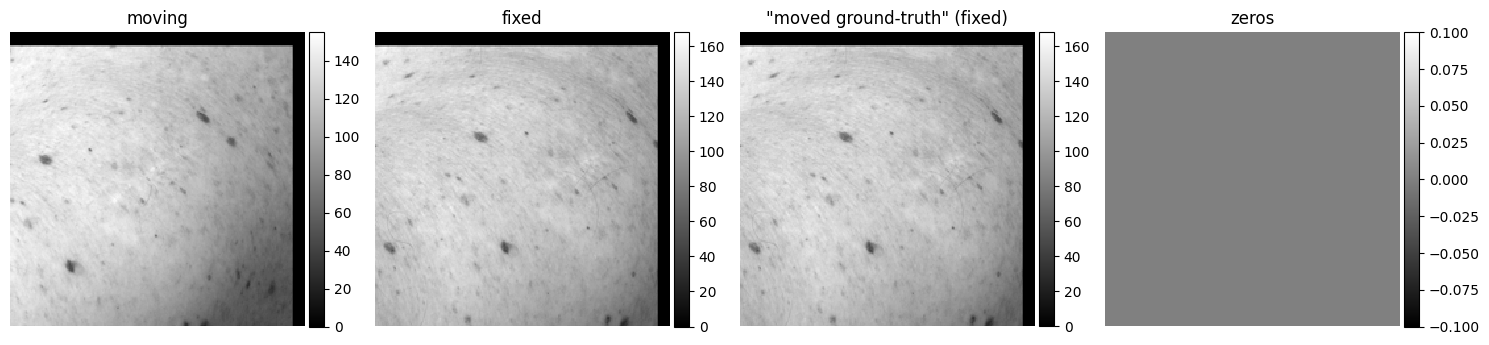

(<Figure size 1500x375 with 8 Axes>,
 array([<Axes: title={'center': 'moving'}>,
        <Axes: title={'center': 'fixed'}>,
        <Axes: title={'center': '"moved ground-truth" (fixed)'}>,
        <Axes: title={'center': 'zeros'}>], dtype=object))

In [425]:
# Visualize individual slices
for i, img in enumerate(in_sample + out_sample):
    print(f"Slice {i} shape: {img.shape}")

# visualize
images = [img[0, :,:, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', '"moved ground-truth" (fixed)', 'zeros']

print(np.array(images[0]).shape)


# Print some information before plotting
print("Max values of slices:")
for i, img in enumerate(images):
    print(f"Slice {i}: {np.max(img)}")

# Plot slices
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)


# # visualize
# images = [img[0, :, :, 0] for img in in_sample + out_sample] 
# titles = ['moving', 'fixed', '"moved ground-truth" (fixed)', 'zeros']
# ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [426]:
nb_epochs = 5
steps_per_epoch = 20
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/5
20/20 - 67s - loss: 167.5408 - vxm_dense_transformer_loss: 167.5408 - vxm_dense_flow_loss: 0.0021 - 67s/epoch - 3s/step
Epoch 2/5
20/20 - 63s - loss: 151.1242 - vxm_dense_transformer_loss: 151.1241 - vxm_dense_flow_loss: 0.0069 - 63s/epoch - 3s/step
Epoch 3/5
20/20 - 63s - loss: 124.1931 - vxm_dense_transformer_loss: 124.1926 - vxm_dense_flow_loss: 0.0500 - 63s/epoch - 3s/step
Epoch 4/5
20/20 - 63s - loss: 95.5976 - vxm_dense_transformer_loss: 95.5961 - vxm_dense_flow_loss: 0.1435 - 63s/epoch - 3s/step
Epoch 5/5
20/20 - 63s - loss: 79.3081 - vxm_dense_transformer_loss: 79.3058 - vxm_dense_flow_loss: 0.2328 - 63s/epoch - 3s/step


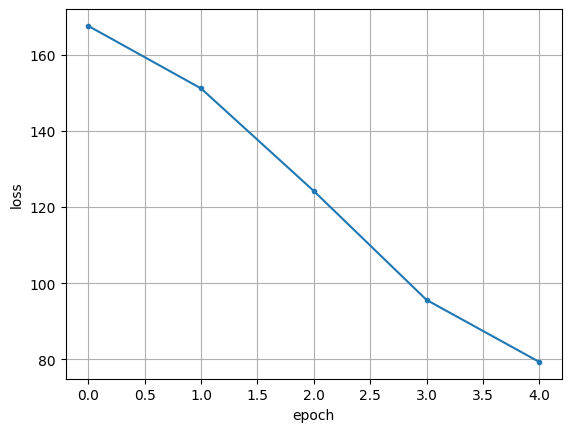

In [427]:
# as before, let's visualize what happened
plot_history(hist)

In [447]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size=1)
val_input, _ = next(val_generator)

In [448]:
print(np.array(val_input).shape)

(2, 1, 224, 224, 1)


In [449]:
# registration of this validation pair
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 0s 55ms/step


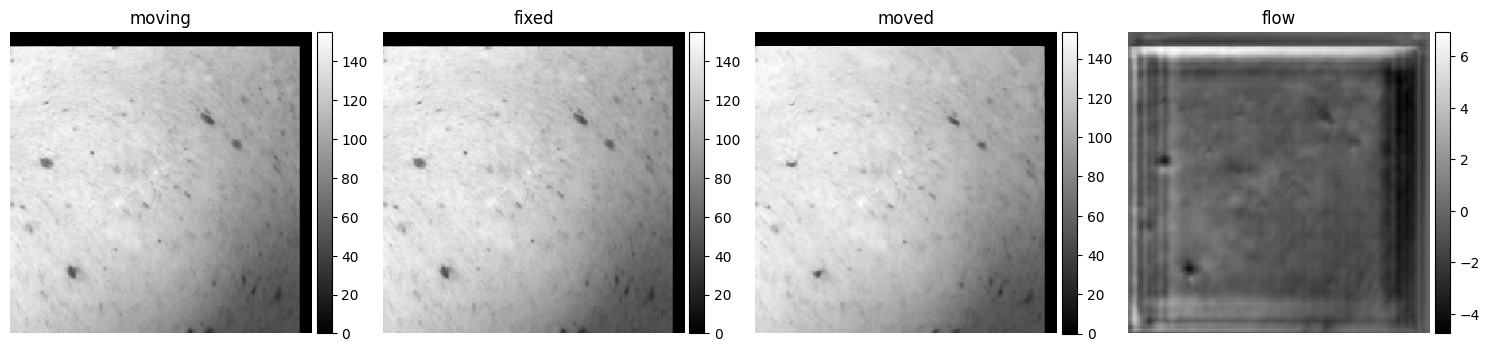

In [450]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);